In [1]:
import math as m
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
%matplotlib inline

### References

The referenced chapters, formulae and problems are from the book [Computational Physics, by Jos Thijssen](https://www.cambridge.org/core/books/computational-physics/BEE73B0139D4A9993193B57CDC62096E#fndtn-information).

Work in progress, might be wrong!

What follows is copied directly from hatree-fock.ipynb, check that one for details. The interesting new part is after this portion. If you already looked over the Hartree-Fock, you can skip it.

In [2]:
# 3.26, 4.16
def Gaussian(alpha, r):
    return m.exp(-alpha*r*r);

In [3]:
alpha=(13.00773, 1.962079, 0.444529, 0.1219492);

In [4]:
# see 4.114 and 4.116
def F0(t):
    p = m.sqrt(t);
    if t==0:
        return 1.;
    a = 1. / p;
    return a * m.sqrt(m.pi) / 2. * m.erf(p);

In [5]:
# 4.98
def Rp(alpha, beta, Ra, Rb):
    return (alpha*Ra + beta*Rb) / (alpha + beta);

In [6]:
# 4.100
def OverlapTwoCenters(alpha, beta, Ra, Rb):
    difR = Ra - Rb;
    len2 = np.dot(difR, difR);
    aplusb = alpha + beta;
    ab = alpha * beta / aplusb;
    return m.pow(m.pi / aplusb, 3./2.) * m.exp(-ab * len2);

In [7]:
# 4.103
def KineticTwoCenters(alpha, beta, Ra, Rb): #this is correct, checked
    difR = Ra - Rb;
    len2 = np.dot(difR, difR);
    aplusb = alpha + beta;
    ab = alpha * beta / aplusb;
    O = m.pow(m.pi/aplusb, 3./2.) * m.exp(-ab * len2); # it's actually the overlap, check the OverlapTwoCenters
    return ab * (3. - 2. * ab * len2) * O; #this can be optimized with already computed overlap, see above

In [8]:
# 4.115
def Nuclear(alpha, beta, Ra, Rb, Rc, Z = 1.):
    aplusb = alpha + beta;
    ab = alpha * beta / aplusb;
    difR = Ra - Rb;
    len2 = np.dot(difR, difR);
    difRc = Rp(alpha, beta, Ra, Rb) - Rc;
    len2c = np.dot(difRc, difRc);
    K = m.exp(-ab*len2);
    return -2. * m.pi * Z / aplusb * K * F0(aplusb*len2c);

In [9]:
# 4.123
def TwoElectronTwoCenter(alpha, beta, gamma, delta, Ra, Rb, Rc, Rd):
    RP = Rp(alpha, gamma, Ra, Rc);
    RQ = Rp(beta, delta, Rb, Rd);
    alphaplusgamma = alpha + gamma;
    betaplusdelta = beta + delta;
    Rac = Ra - Rc;
    Rbd = Rb - Rd;
    Rpq = RP - RQ;
    Racl2 = np.dot(Rac, Rac);
    Rbdl2 = np.dot(Rbd, Rbd);
    Rpql2 = np.dot(Rpq, Rpq);
    return 2. * m.pow(m.pi, 5./2.) / (alphaplusgamma * betaplusdelta * m.sqrt(alphaplusgamma+betaplusdelta)) * \
           m.exp(-alpha*gamma/alphaplusgamma*Racl2 - beta*delta/betaplusdelta*Rbdl2) *\
           F0(alphaplusgamma*betaplusdelta / (alphaplusgamma+betaplusdelta) * Rpql2);

In [10]:
basisSize = 4; # for each atom

In [11]:
H = np.zeros((basisSize * 2, basisSize * 2));
O = np.zeros((basisSize * 2, basisSize * 2));

X = 1.; # distance between atoms

R0 = np.array([0, 0, 0]);
R1 = np.array([X, 0, 0]);
for i in range(basisSize):
    for j in range(basisSize):        
        O[i][j] = OverlapTwoCenters(alpha[i], alpha[j], R0, R0);
        O[4 + i][j] = OverlapTwoCenters(alpha[i], alpha[j], R1, R0);
        O[i][4 + j] = OverlapTwoCenters(alpha[i], alpha[j], R0, R1);
        O[4 + i][4 + j] = OverlapTwoCenters(alpha[i], alpha[j], R1, R1);                
        H[i][j] = KineticTwoCenters(alpha[i], alpha[j], R0, R0) + Nuclear(alpha[i], alpha[j], R0, R0, R0) + Nuclear(alpha[i], alpha[j], R0, R0, R1);
        H[4 + i][j] = KineticTwoCenters(alpha[i], alpha[j], R1, R0) + Nuclear(alpha[i], alpha[j], R1, R0, R0) + Nuclear(alpha[i], alpha[j], R1, R0, R1);
        H[i][4 + j] = KineticTwoCenters(alpha[i], alpha[j], R0, R1) + Nuclear(alpha[i], alpha[j], R0, R1, R0) + Nuclear(alpha[i], alpha[j], R0, R1, R1);
        H[4 + i][4 + j] = KineticTwoCenters(alpha[i], alpha[j], R1, R1) + Nuclear(alpha[i], alpha[j], R1, R1, R0) + Nuclear(alpha[i], alpha[j], R1, R1, R1);


In [12]:
Q = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2));
for i in range(basisSize):
    for j in range(basisSize):
        for k in range(basisSize):
            for l in range(basisSize):
                Q[i][j][k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R0, R0, R0);
                Q[i][j][k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R0, R0, R1);
                Q[i][j][basisSize+k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R0, R1, R0);
                Q[i][j][basisSize+k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R0, R1, R1);
                Q[i][basisSize+j][k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R1, R0, R0);
                Q[i][basisSize+j][k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R1, R0, R1);
                Q[i][basisSize+j][basisSize+k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R1, R1, R0);
                Q[i][basisSize+j][basisSize+k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R0, R1, R1, R1);
                Q[basisSize+i][j][k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R0, R0, R0);
                Q[basisSize+i][j][k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R0, R0, R1);
                Q[basisSize+i][j][basisSize+k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R0, R1, R0);
                Q[basisSize+i][j][basisSize+k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R0, R1, R1);
                Q[basisSize+i][basisSize+j][k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R1, R0, R0);
                Q[basisSize+i][basisSize+j][k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R1, R0, R1);
                Q[basisSize+i][basisSize+j][basisSize+k][l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R1, R1, R0);
                Q[basisSize+i][basisSize+j][basisSize+k][basisSize+l]=TwoElectronTwoCenter(alpha[i], alpha[j], alpha[k], alpha[l], R1, R1, R1, R1);

In [13]:
Qt = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2));
for p in range(2*basisSize):
    for q in range(2*basisSize):
        for r in range(2*basisSize):
            for s in range(2*basisSize):
                Qt[p][q][r][s] = 2. * Q[p][q][r][s] - Q[p][r][s][q];

From here is the new part, specific to Car-Parrinello method.

First, the part from 9.3.1, Car-Parrinello only for the electronic part.

The computation can take a while, maybe it's not a good idea to launch it in binder.

In [14]:
v = 0;
for i in range(2 * basisSize):
    for j in range(2 * basisSize):
        v += O[i][j];
v = 1. / m.sqrt(v);

C = np.array([v, v, v, v, v, v, v, v]);
Cprev = C.copy();
Ct = np.zeros((2 * basisSize));

OC = np.zeros((2 * basisSize));
OCt = np.zeros((2 * basisSize));
OOC = np.zeros((2 * basisSize));

dt = 0.1; # time step
dt2 = dt * dt;
dt4 = dt2 * dt2;
gamma = 20.; # frictional constant

#mass = 4.;
OneMinusGamma = 1. - 0.5*gamma*dt;
OnePlusGamma = 1. + 0.5*gamma*dt;

numPoints = 1000; # 4000; # Use 4000 and get really close to the Hartree-Fock result
energies = np.zeros((numPoints));

In [15]:
F = np.zeros((2*basisSize, 2*basisSize));
oldE = 100;
for cycle in range(numPoints):

    # Fock matrix computation
    for i in range(2*basisSize):
        for j in range(2*basisSize):
            F[i][j] = H[i][j];
            for k in range(2*basisSize):
                for l in range(2*basisSize):
                    F[i][j] += Qt[i][k][j][l] * C[k] * C[l];
        
    # compute energy
    Eg = C.dot(H + F).dot(C) + 1. / X;

    #print(Eg);
    
    energies[cycle] = Eg;
    if abs(oldE-Eg) < 1E-12:
        break;    
        
    # Verlet
                    
    # compute Ct - 9.31, but with friction force added - the formula is wrong, F gets divided by 4
    
    Ct = (2. * C - OneMinusGamma * Cprev - F.dot(C) / 4. * dt2) / OnePlusGamma;
                
    # determine lambda - see 9.32 - but be careful, it's wrong! Get it from 9.28 by replacing C[r] = Ct[r] - lambda * h^2 * sum(S[r][s]*C[s]), h^4 and h^2 are missing (here h is dt)
     
    OC = O.dot(C);
    OCt = O.dot(Ct);
    OOC = O.dot(OC);
    
    a = OOC.dot(OC) * dt4;
    b = -2. * OC.dot(OCt) * dt2;
    c = OCt.dot(Ct) - 1.;
    
    delta = b*b - 4.*a*c;
    if delta < 0:
        print("Delta negative!");
        break;
    
    lam = (-b-m.sqrt(delta)) / (2. * a);
    if lam < 0:
        lam = (-b+m.sqrt(delta)) / (2. * a);
        if lam < 0:
            print("Negative solutions!");
            break;

    # now adjust the newly computed Cs    
    
    Ct -= lam * dt2 * OC;
        
    # switch to the next step
    Cprev = C;
    C = Ct;            
    oldE = Eg;

In [16]:
print(Eg);

-1.076459371077918


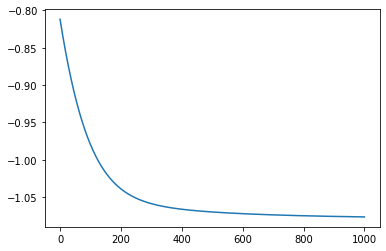

In [17]:
x = np.linspace(0, numPoints, numPoints);
plt.plot(x, energies);

In [18]:
print(C);

[0.08217006 0.14761569 0.12722025 0.01989657 0.08217006 0.14761569
 0.12722025 0.01989657]
